### Les Modules

In [ ]:
# Importation des modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import typing as tp
import utilitaire as ut
import math_mod as mm
import plotting as pltg
import sampling_techniques as st

from pinard import nirs_set as n_set
from pinard import preprocessor as pp
from pinard.nirs_pipelines import FeatureAugmentation
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from scikeras.wrappers import KerasRegressor
from scipy.stats import kstest, norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, SpatialDropout1D, BatchNormalization, Flatten, Dropout, Input
from xgboost import XGBRegressor

### Les préprocessing

In [2]:
# Préprocessing à effectuer pour les données spectrals

preprocessing = [   
                    ('id', pp.IdentityTransformer()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())]))
                ]

### Fonctions

In [3]:
# Fonction pour supprimer l'affichage des warnings sklearn

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
# Create the keras model in the scikeras wrapper format (meta arg)

def keras_model(meta: tp.Dict[str, tp.Any]):

    input_shape = meta["X_shape_"][1:]
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SpatialDropout1D(0.08))
    model.add(Conv1D (filters=8, kernel_size=15, strides=5, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Conv1D (filters=64, kernel_size=21, strides=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D (filters=32, kernel_size=5, strides=3, activation='elu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [5]:
# Fonction transformant des ndarray en dataframes, et applique (au choix) un préprocessing, un retrait des outliers, et un MinMaxScaler

def to_dataframe(features: tp.Union[pd.DataFrame, np.ndarray, list],
                 labels: tp.Union[pd.DataFrame, np.ndarray, list],
                 pre_pro: bool=True,
                 scale: bool=True,
                 rm_outliers: bool=True,
                 random_state: tp.Union[int, None]=0) -> tp.Tuple[pd.DataFrame, pd.DataFrame]:
    
    # Transforme les features en dataframe, et le reshape, si besoin
     
    if not isinstance(features, pd.DataFrame):

        if len(features.shape) == 1:
            
            features = features.reshape(-1, 1)

        features = pd.DataFrame(data=features, columns=[i for i in range(0, features.shape[1], 1)])

    # Transforme les labels en dataframe, et le reshape, si besoin

    if not isinstance(labels, pd.DataFrame):

        if len(labels.shape) == 1:
            
            labels = labels.reshape(-1, 1)
                        
        labels = pd.DataFrame(data=labels, columns=["labels {}".format(i) for i in range(0, labels.shape[1], 1)])
        
    # Retire les outliers

    if rm_outliers:

        iso_f = IsolationForest(random_state=random_state)
        outliers = iso_f.fit_predict(features)

        features = features[outliers != -1]
        labels = labels[outliers != -1]

    # Effectue un préprocessing sur les features

    if pre_pro:

        p = FeatureUnion(preprocessing).fit(features)
        features = pd.DataFrame(data=p.transform(features), columns=[i for i in range(0, p.transform(features).shape[1], 1)])
    
    # Effectue un scale sur les labels

    if scale:

        sclr = MinMaxScaler().fit(labels)
        labels = pd.DataFrame(data=sclr.transform(labels), columns=sclr.get_feature_names_out())
    
    return (features, labels)

In [6]:
# Fonction permettant d'effectuer le test de kolmogorov et smirnov pour tester la normalité de la distribution de chaques variables(features + labels)

# Note : la fonction effectue des moyennes pour s'assurer de la normalité

def kolm_smir_test(features: pd.DataFrame, labels: pd.DataFrame, n_iter: int=20) -> pd.DataFrame:

    # Initialiser le futur dataframe des résultats

    df_kolm_smirnov = {"val_statistics" : [], "p-value" : []}

    # Récupérer le nombre de lignes

    n = len(features)

    df_concat = pd.concat([features, labels], axis=1)

    # Pour chaque colonne de variables

    for col in range(df_concat.shape[1]):

        # Initialiser deux tableaux, un pour la valeur de la statistique de test, l'autre pour la p-value

        tab_stat = []

        tab_pval = []

        # Pour un nombre d'itérations donné

        for i in range(n_iter):

            # Calculer la moyenne et l'écart_type d'une colonne

            moy = mm.moy_func(df_concat.iloc[:, col].values.tolist())
            ecart_type = mm.std_func(df_concat.iloc[:, col].values.tolist())

            # Générer la distribution normale qui devrait résulté de ces deux paramètres

            norm_tmp = norm.rvs(loc=moy, scale=ecart_type, size=n, random_state=col+i)

            # Calculer la statistique de test, et la p-value correspondante, puis les ajouter aux tableaux

            stat, pval = kstest(df_concat.iloc[:, col].values.tolist(), norm_tmp)
            tab_stat.append(stat)
            tab_pval.append(pval)

        # Ajouter les valeurs moyennes de chaque tableau au futur dataframe

        df_kolm_smirnov["val_statistics"].append(mm.moy_func(tab_stat))
        df_kolm_smirnov["p-value"].append(mm.moy_func(tab_pval))

    return pd.DataFrame(df_kolm_smirnov)

In [7]:
# Fonction permettant d'afficher les dimensions des jeux de données d'entraînement et de test 

def print_shape(a: pd.DataFrame,
                b: pd.DataFrame,
                c: pd.DataFrame,
                d: pd.DataFrame) -> None:

    print("x_train : {}\ny_train : {}\nx_test : {}\ny_test : {}".format(a.shape, b.shape, c.shape, d.shape))

In [8]:
# Fonction affichant un violinplot de la distribution des valeurs de la variable cible, entre le train_set et le test_set

def plot_distrib(y_train: pd.DataFrame, y_test: pd.DataFrame, largeur: int=10, hauteur: int=6) -> None:

    new_df = pd.concat([y_train.assign(Set="Train"), y_test.assign(Set="Test")], axis=0)

    new_df.columns = new_df.columns.str.replace('labels 0', 'Target')

    plt.figure(figsize=(largeur, hauteur))

    sns.violinplot(data=new_df, x="Target", y="Set")

    plt.title("Violinplot de la distribution des valeurs de la variable cible, dans le Train set et le Test set", pad=10)

    plt.show()

In [9]:
# Fonction affichant les scores de prédictions

def print_scores(y_test: tp.Union[tp.List[float], np.ndarray], pred: tp.Union[tp.List[float], np.ndarray]) -> None:

    for metric in ["mape", "mse", "mae", "rmse", "r2"]:

        print("{} = {}".format(metric.upper(), ut.metric_choice(y_test, pred, scoring=metric)))

In [10]:
# Fonction retournant le score de performance

def score_perf(vec: tp.Tuple[float]) -> float:

    max_ = max(vec)

    return  1/(((max_/vec[0])*vec[0])**2 +
               ((max_/vec[1])*vec[1])**2 +
               ((max_/vec[2])*vec[2])**2 +
               ((max_/vec[3])*vec[3])**2 +
               ((max_/vec[4])*vec[4])**2)**0.5

In [11]:
# Fonction calculant un score de performance

def compute_score_perf(y_test: tp.Union[tp.List[float], np.ndarray], pred: tp.Union[tp.List[float], np.ndarray], **kwargs) -> float:

    # Vecteur de coordonnées 

    vec_coord = []

    # Chaque métriques devient une coordonnée du vecteur

    for metric in ["mape", "mse", "mae", "rmse", "r2"]:

        if metric != "r2":

            vec_coord.append(ut.metric_choice(y_test, pred, scoring=metric))

        else:

            vec_coord.append(1 - ut.metric_choice(y_test, pred, scoring=metric))

    vec_coord = tuple(vec_coord)

    # Retouner le score de performance

    return score_perf(vec_coord)

In [12]:
# Fonction permettant d'évaluer l'impact de la dissimilarité sur le modèle

def test_dis_impact(features: pd.DataFrame,
                    labels: pd.DataFrame,
                    test_size: int,
                    dic_res: tp.Dict[tp.Tuple[str, int], float],
                    estimator: object,
                    n_cluster: int,
                    pca: tp.Union[int, float]) -> None:

    # Pour la récupération du minimum et du maximum de dissimilarité

    tab_temp = ['min', 'max', 'random']

    for min_max_rd in tab_temp:

        # Récupération de la technique et du random_state
        
        if min_max_rd != 'random':

            dic_temp = ut.find_best_model(dic_res, min_max_rd)

            tech, r_state = tuple(dic_temp.keys())[0]

        else:

            tech, r_state = ('random', 42)

        # Splitting des données

        f_train, f_test, l_train, l_test = st.sampling_train_test_split(features=features,
                                                            labels=labels,
                                                            test_size=test_size,
                                                            tech=tech,
                                                            n_cluster=n_cluster,
                                                            pca=pca,
                                                            random_state=r_state)

        # Entrainement de l'estimateur

        model = estimator
        model.fit(f_train, l_train.values.reshape(-1,))

        # Affichage des résultats

        print("{} dissimilarité = ({}, {})\n".format(min_max_rd.upper(), tech, r_state))

        print("Score de performance = {}".format(compute_score_perf(l_test, model.predict(f_test))))

        pltg.plot_result(labels, f_train, f_test, l_train, l_test, model, largeur=10, hauteur=10)

### Test de l'impact du mode de partage des données sur la dissimilarité entre le train et le test split

In [14]:
# Mise en place du tableau contenant les techniques de splitting à tester

tab_tech = ["k_mean", "kennard_stone", "cluster", "custom", "random", "SPlit", "spxy", "systematic"]

# Paramètrage des préprocessing à effectuer sur les données

pre_pro = True
scale = True
rm_outliers = False
random_state = 0

# Chargement des données

n = n_set.NIRS_Set('data')
features, labels = n.load('Xcal.txt', 'Ycal.txt', x_hdr=0, y_hdr=0, y_cols=0)
features, labels = to_dataframe(features=features,
                                labels=labels,
                                pre_pro=pre_pro,
                                scale=scale,
                                rm_outliers=rm_outliers,
                                random_state=random_state)

In [15]:
# Vérification de la normalité des variables par le test de Kolmogorov-Smirnov

df_kst = kolm_smir_test(features=features,
                        labels=labels,
                        n_iter=20)

# Sauvegarde des résultats

df_kst.to_csv("Résultats_Test_normalité.csv")

# Récupération du nombre de variables, du ratio n('variables-normales')/n('variable')

n_var = features.shape[1] + labels.shape[1]
n_var_nn = len(df_kst[df_kst["p-value"] < 0.05])
ratio_var = n_var_nn/n_var*100

# Affichage des résultats

print(f"Il y a {n_var_nn} variables 'non-normales' sur {n_var} variables dans le dataset. Soit {ratio_var:.2f}% des variables.")

# (Note : Nous avons ici 1509 'non-normales' car il y a un préprocessing, si nous n'effectuons pas les préprocessings, il y a 0 variables 'non-normales'.)

Il y a 1509 variables 'non-normales' sur 19360 variables dans le dataset. Soit 7.79% des variables.


##### !!! Cellule à éxécuter que si on ne possède pas le csv contenant les splits !!!

In [14]:
# # Paramètrage du test

# n_iter = 500
# test_size = 0.2
# n_cluster = 8
# pca = 0.999
# save = True

# # Récupération des splits

# df_splitting = ut.splitting_state_to_csv(features=features,
#                                          labels=labels,
#                                          test_size=test_size,
#                                          n_iter=n_iter,
#                                          tab_tech=tab_tech,
#                                          n_cluster=n_cluster,
#                                          pca=pca,
#                                          save=save)

# # Calcul de la dissimilarité

# dic_diss = ut.get_dic_diss(df_splitting, features, labels)

# # Transformation en dataframe

# df_res = ut.transform_results(dic_diss, "dataframe")

# # Sauvegarde des résultats

# df_res = pd.concat([df_splitting, df_res['Score']], axis=1)
# df_res.to_csv("splitting_state_prtrt_scl_rdstt_0.csv", index=False)
# df_res.rename(columns = {'tech':'Technique'}, inplace=True)

##### Si on  possède le csv contenant les splits

In [16]:
# Paramètres utilisés

n_iter = 500
test_size = 0.2
n_cluster = 8
pca = 0.999

# Lecture du fichier résultat

df_res = pd.read_csv("splitting_state_prtrt_scl_rdstt_0.csv")
df_res.rename(columns = {'tech':'Technique'}, inplace = True)

# Mise en place du dictionnaire de score de dissimilarité

dic_diss = {}

for i in range(len(df_res)):

    dic_diss[(df_res.loc[i, ('Technique')], df_res.loc[i, ('random_state')])] = df_res.loc[i, ('Score')]

### Visualisation des résultats

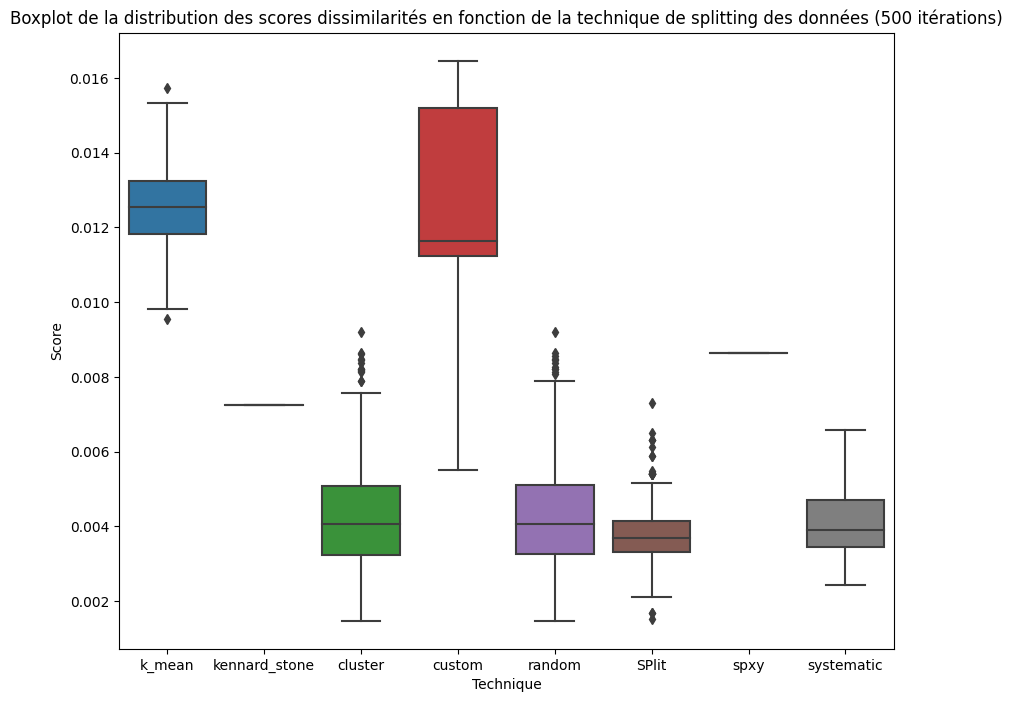

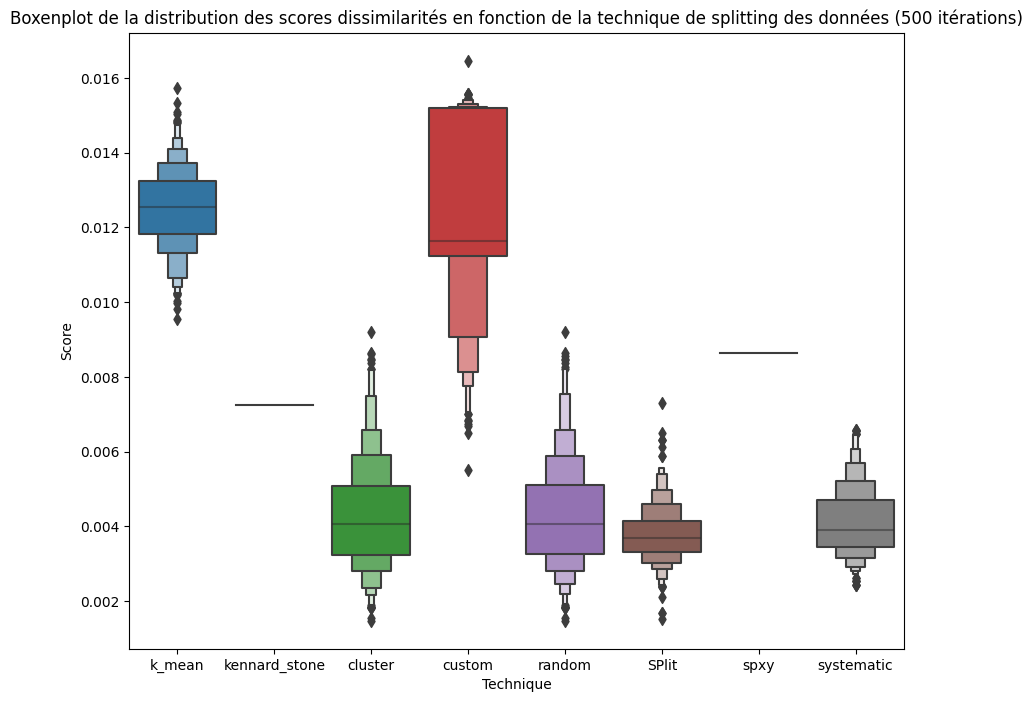

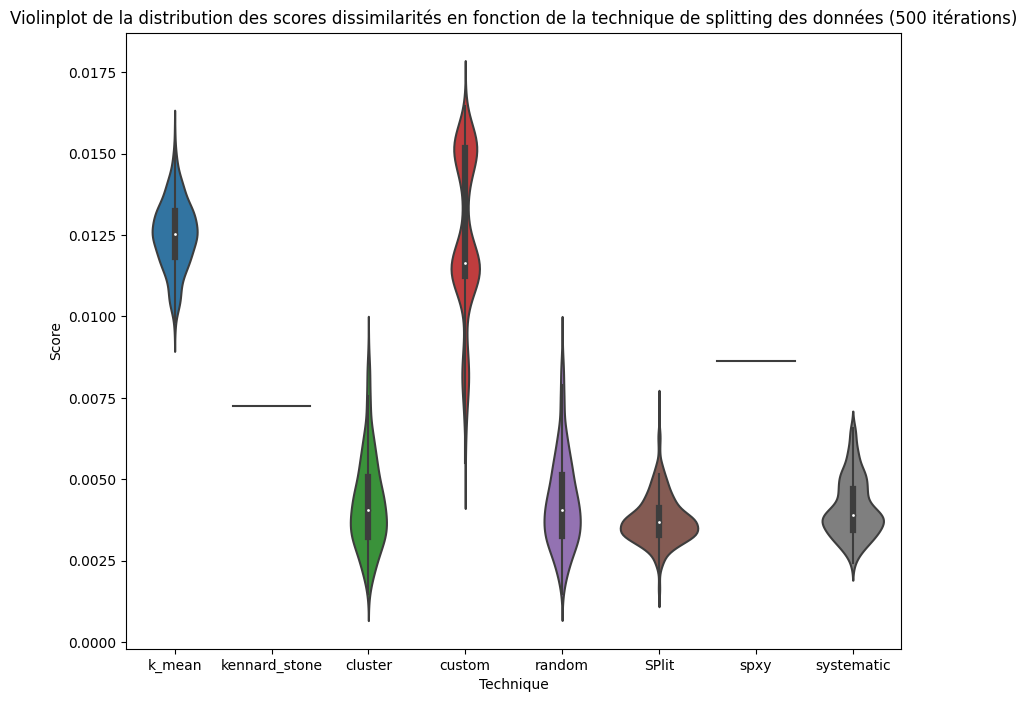

In [18]:
# Affichage des résultats

pltg.plot_box_boxen_violin(x=df_res["Technique"],
                           y=df_res["Score"], 
                           type_graph="box", 
                           title="Boxplot de la distribution des scores dissimilarités en fonction de la technique de splitting des données ({} itérations)".format(n_iter),
                           largeur=10,
                           hauteur=8,
                           grid=False)

pltg.plot_box_boxen_violin(x=df_res["Technique"],
                           y=df_res["Score"], 
                           type_graph="boxen", 
                           title="Boxenplot de la distribution des scores dissimilarités en fonction de la technique de splitting des données ({} itérations)".format(n_iter),
                           largeur=10,
                           hauteur=8,
                           grid=False)

pltg.plot_box_boxen_violin(x=df_res["Technique"],
                           y=df_res["Score"], 
                           type_graph="violin", 
                           title="Violinplot de la distribution des scores dissimilarités en fonction de la technique de splitting des données ({} itérations)".format(n_iter),
                           largeur=10,
                           hauteur=8,
                           grid=False)

Technique + valeur du MIN(dissimilarité) : (cluster, 157) = 0.0014748643152415

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)


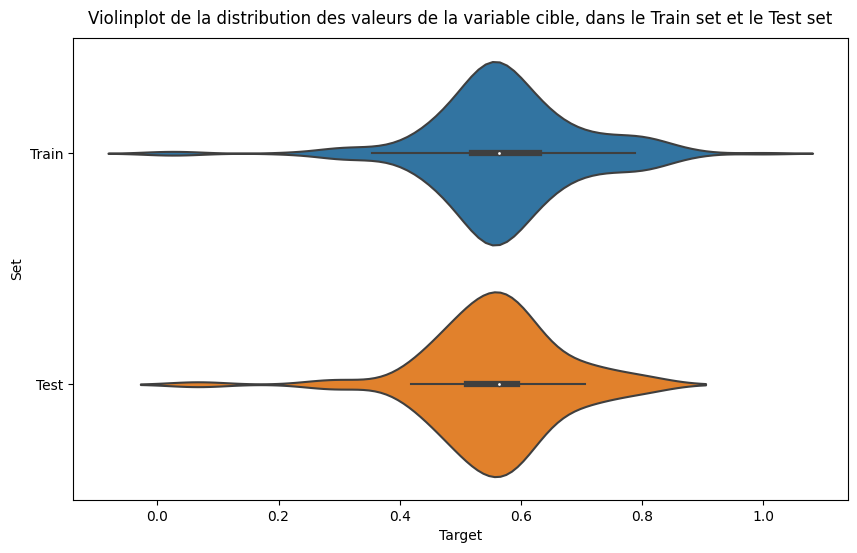

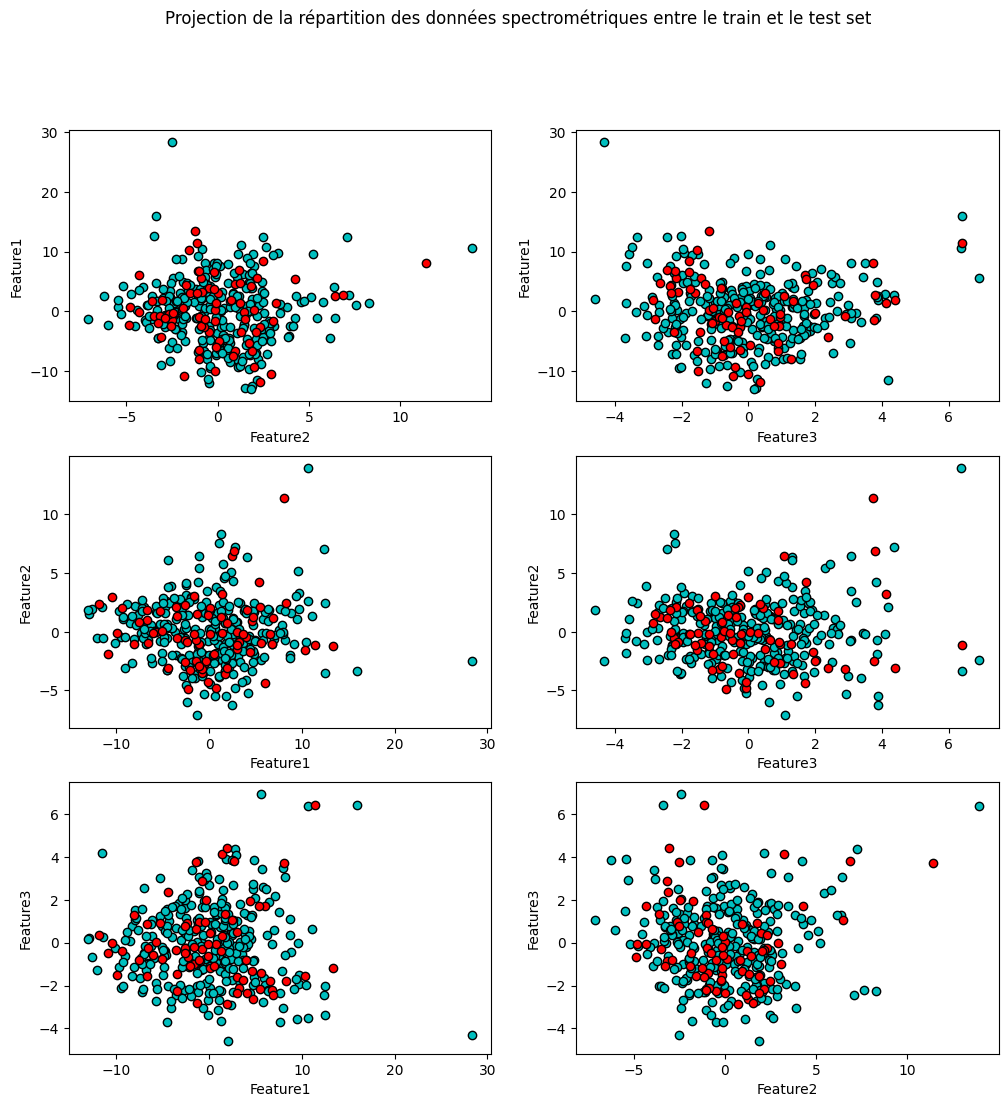

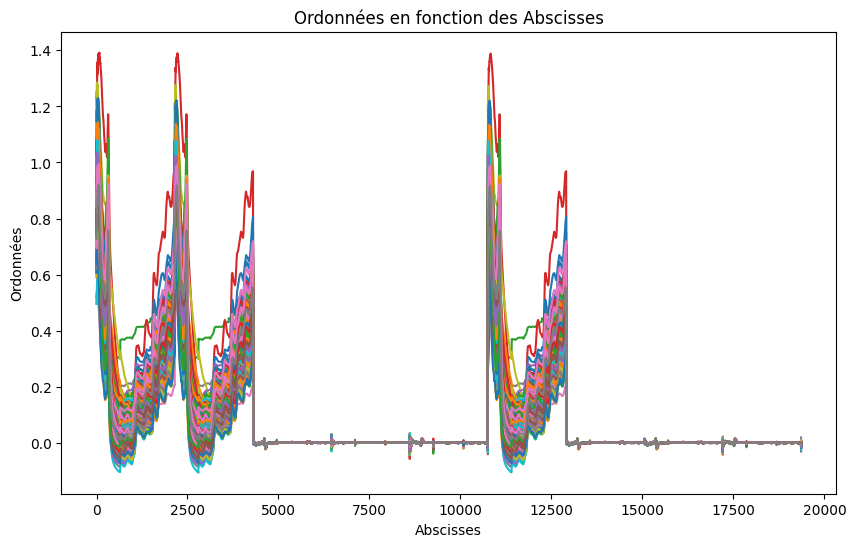

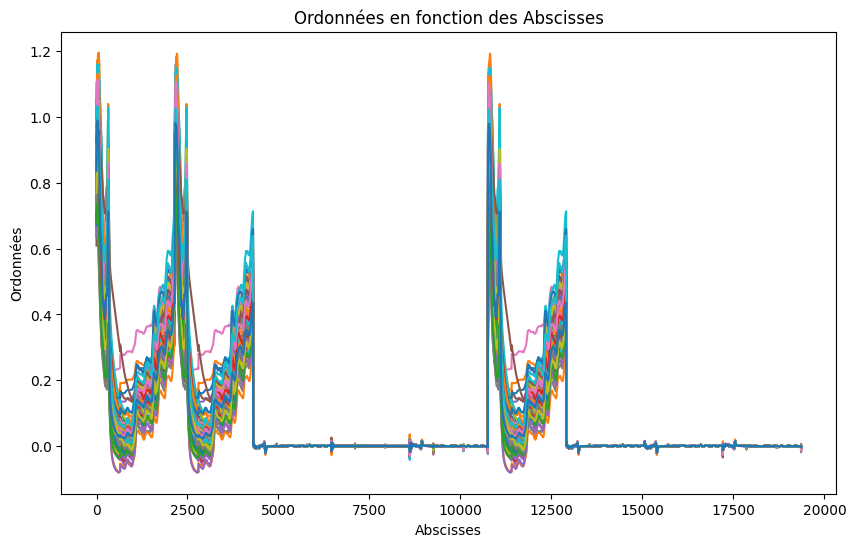

Technique + valeur du MAX(dissimilarité) : (custom, 194) = 0.0164651256054639

x_train : (290, 19359)
y_train : (290, 1)
x_test : (71, 19359)
y_test : (71, 1)


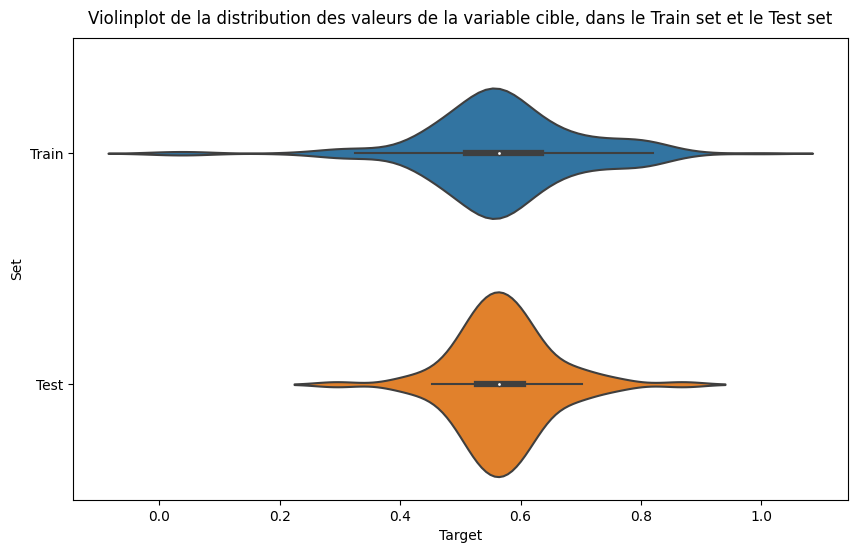

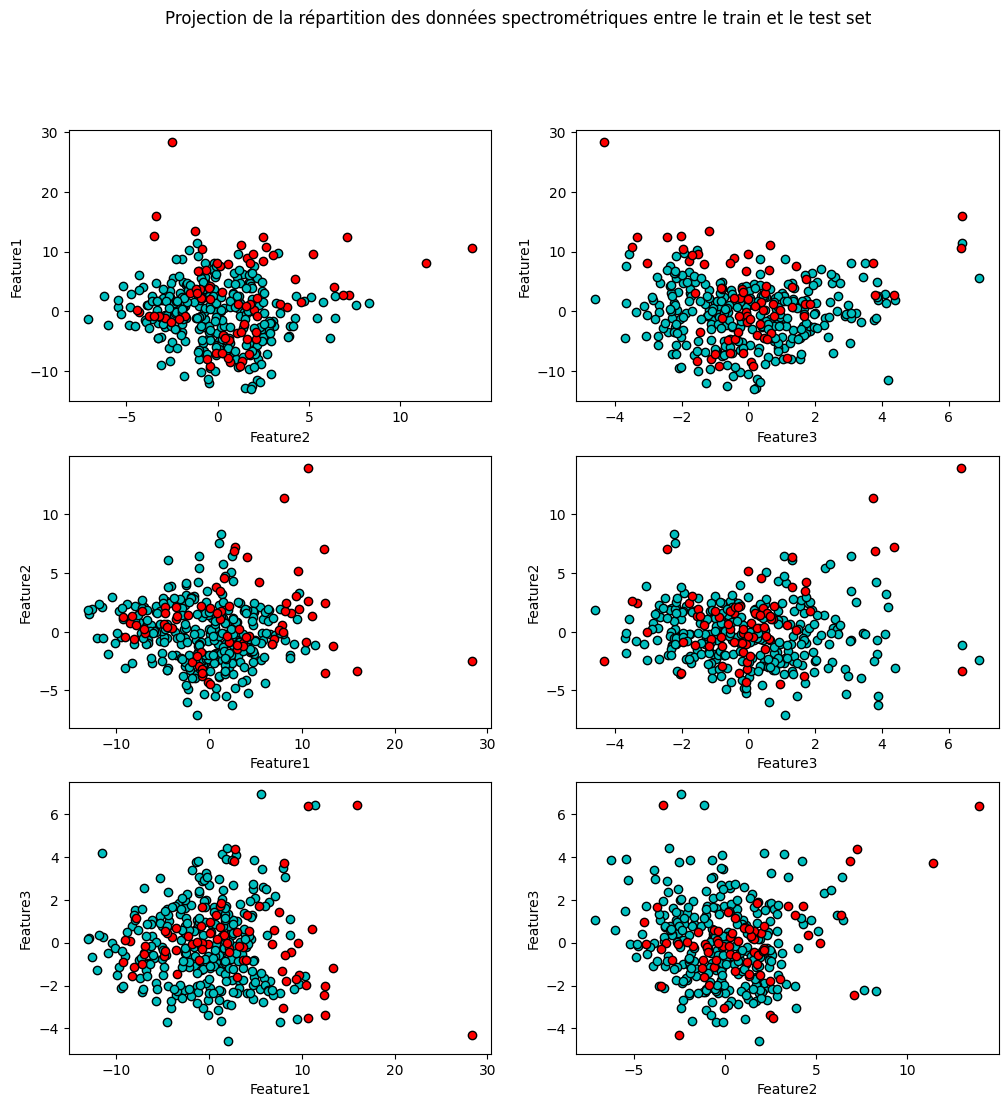

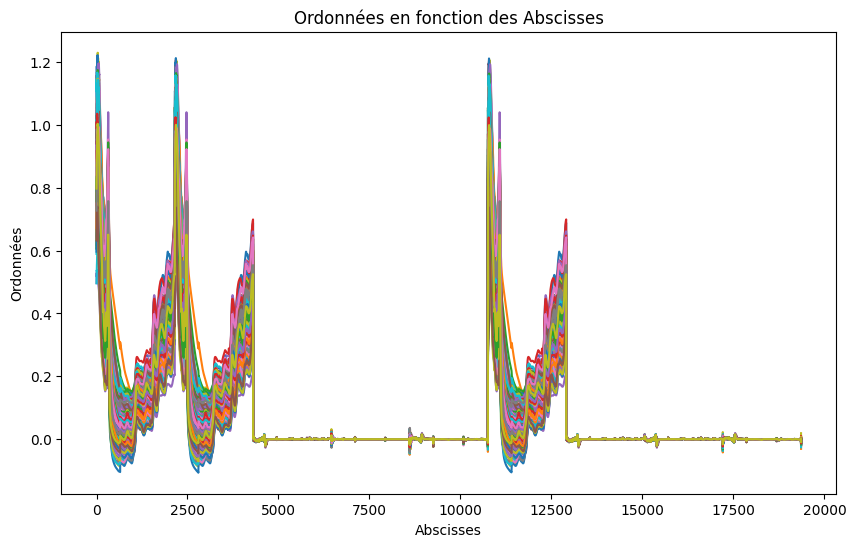

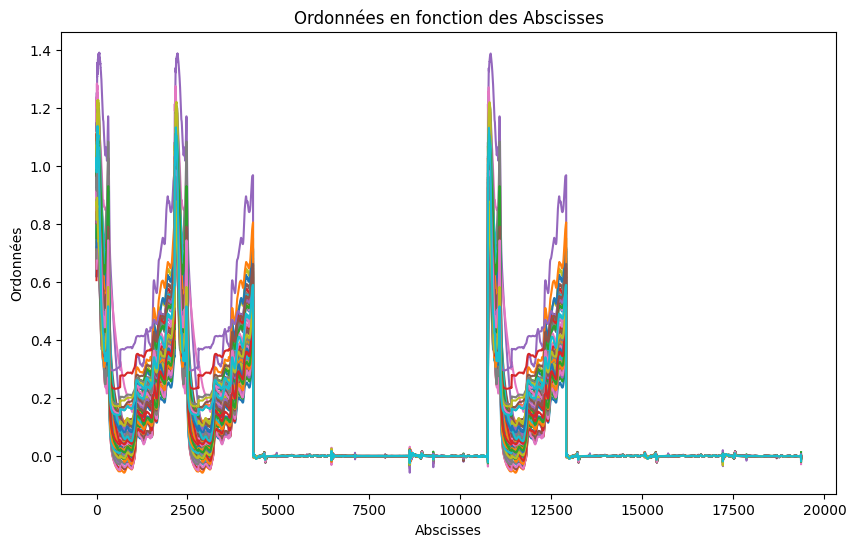

Technique + valeur du RANDOM(dissimilarité) : (random, 42) = 0.0033929988276213

x_train : (289, 19359)
y_train : (289, 1)
x_test : (72, 19359)
y_test : (72, 1)


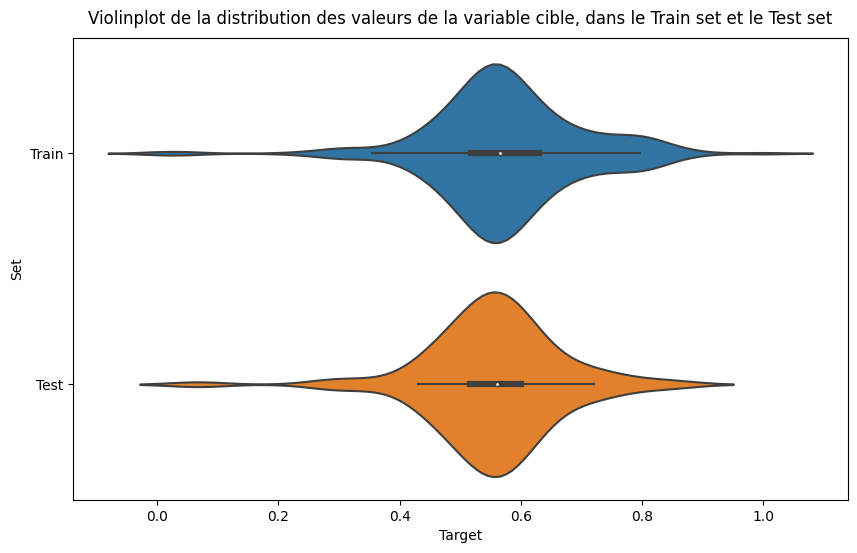

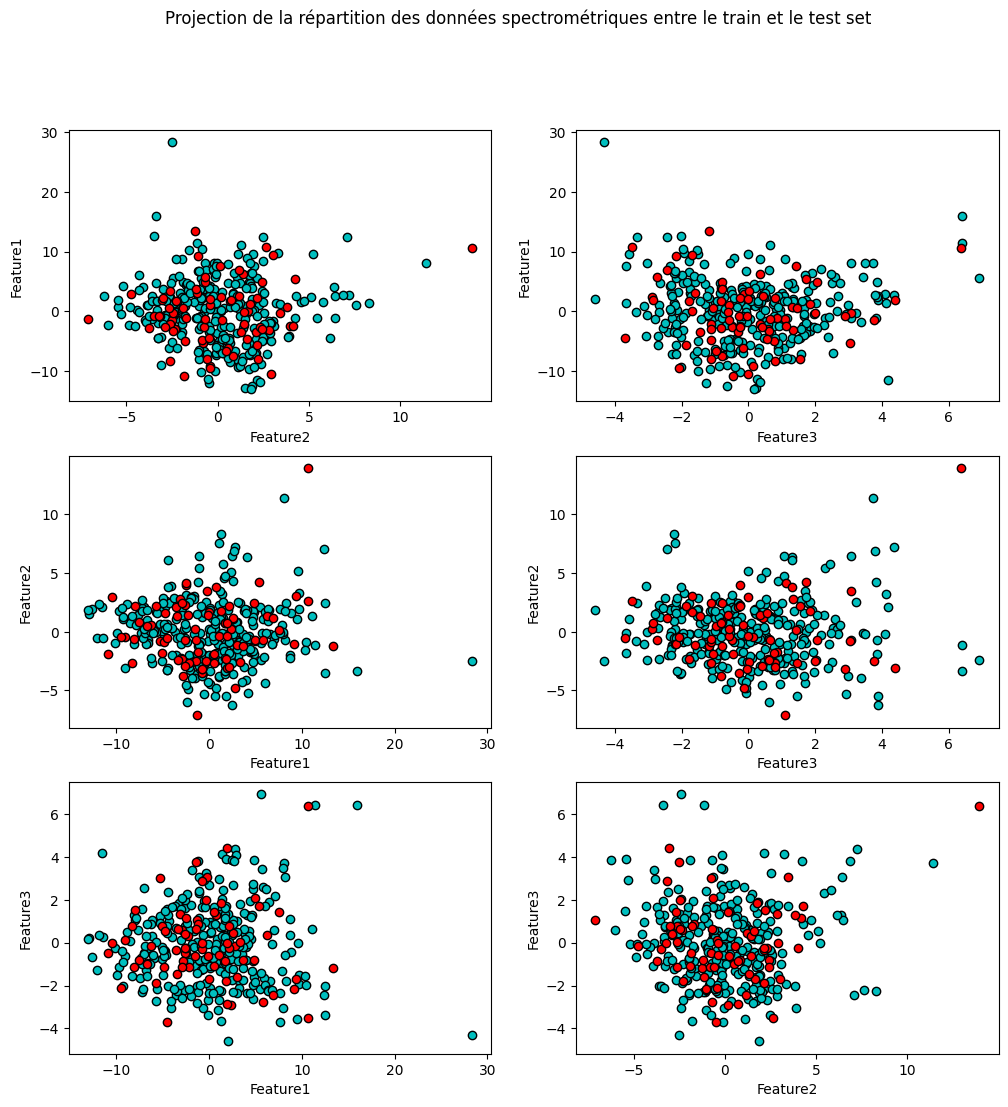

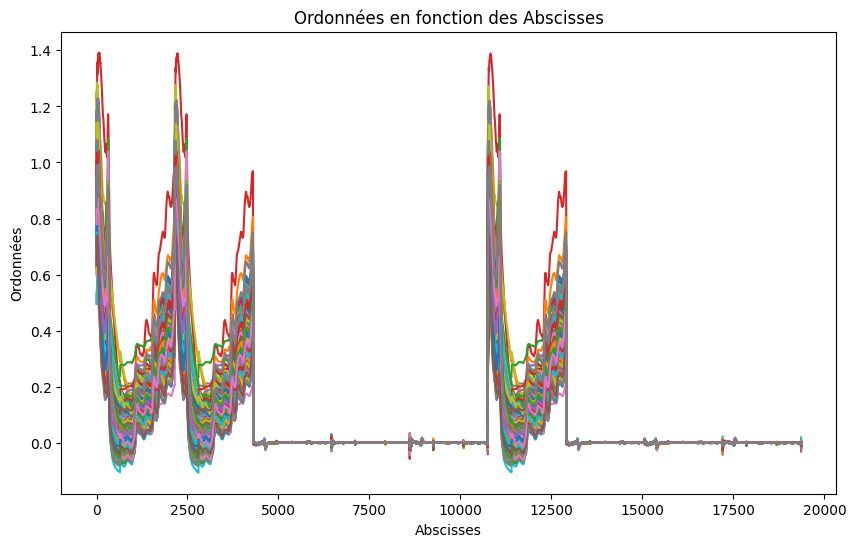

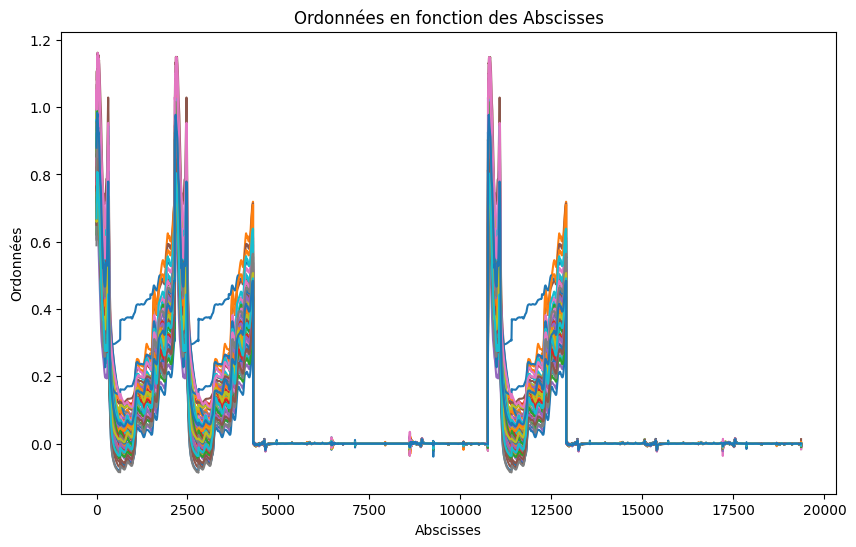

In [20]:
# Récupération, et affichage, du meilleur, et du pire combo (technique de split, configuration), en terme de dissimilarité

for min_max in ["min", "max", "random"]:

    # Récupération des clés et des valeurs depuis le dictionnaire contenant les scores de dissimilarité

    if min_max != "random":

        dic_best_split = ut.find_best_model(dic_diss, min_max)

        key_tech, key_r_state = tuple(dic_best_split.keys())[0]
        value_score = list(dic_best_split.values())[0]

        print("Technique + valeur du {}(dissimilarité) : ({}, {}) = {}\n".format(min_max.upper(), key_tech, key_r_state, value_score))

    else :

        key_tech, key_r_state = min_max, 42
        value_score = dic_diss[(key_tech, key_r_state)]

        print("Technique + valeur du {}(dissimilarité) : ({}, {}) = {}\n".format(min_max.upper(), key_tech, key_r_state, value_score))


    # Splitting des données en fonction du combo

    x_train, x_test, y_train, y_test = st.sampling_train_test_split(features=features,
                                                                    labels=labels,
                                                                    test_size=test_size,
                                                                    tech=key_tech,
                                                                    random_state=key_r_state,
                                                                    n_cluster=n_cluster,
                                                                    pca=pca)

    # Vérificaton des dimensions des jeux de données

    print_shape(x_train, y_train, x_test, y_test)

    # Affichage de la répartitions des données entre le test_set et le training_set

    plot_distrib(y_train, y_test)
    
    pltg.plot_train_test_split(features=features,
                               labels=labels,
                               index_test=list(y_test.index),
                               largeur=12,
                               hauteur=12,
                               title="Projection de la répartition des données spectrométriques entre le train et le test set")

    # Affichage de l'aspect des spectres

    pltg.plot_NIRS_spectra(df_nirs=x_train, largeur=10, hauteur=6)
    pltg.plot_NIRS_spectra(df_nirs=x_test, largeur=10, hauteur=6)

### Évaluation de l'impact de la dissimilarité

#### Partial Least Squared Regressor

MIN dissimilarité = (cluster, 157)

Score de performance = 2.9461849354000567


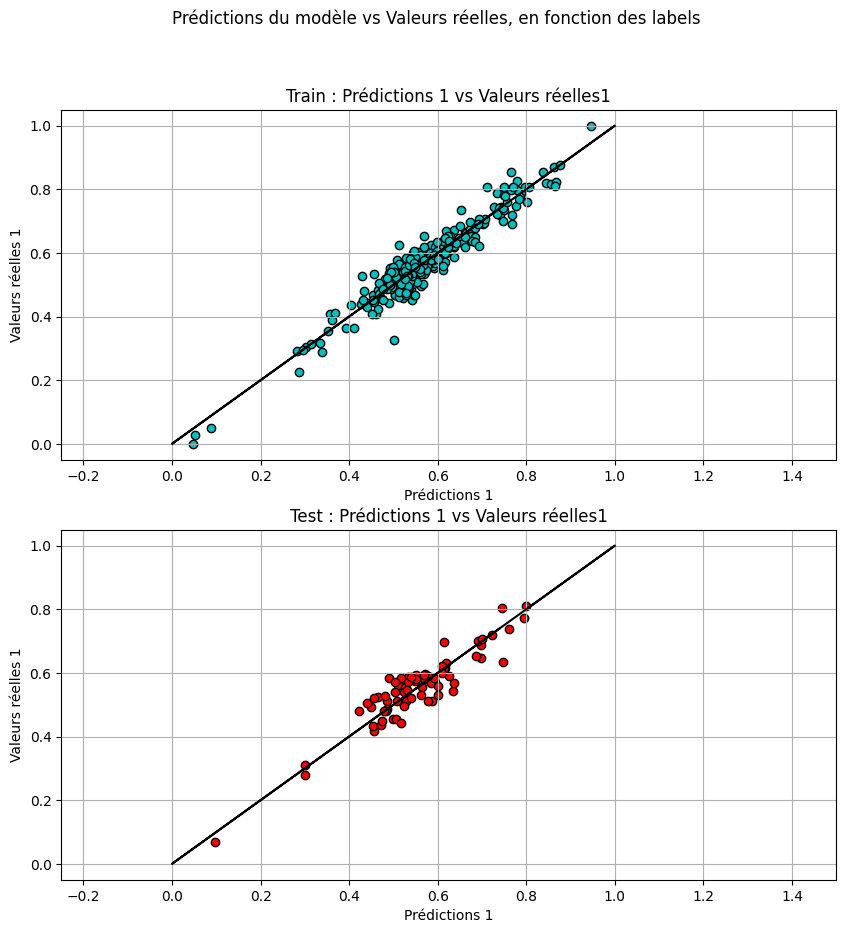

MAX dissimilarité = (custom, 194)

Score de performance = 0.6884868693654435


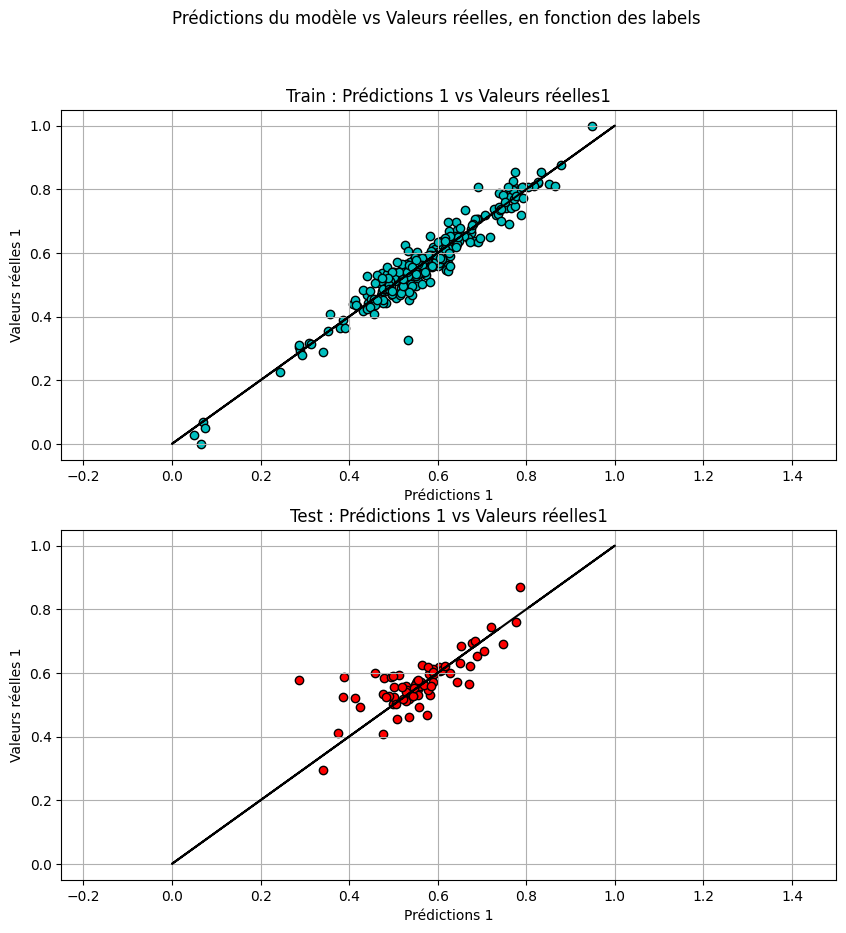

RANDOM dissimilarité = (random, 42)

Score de performance = 2.050289928967931


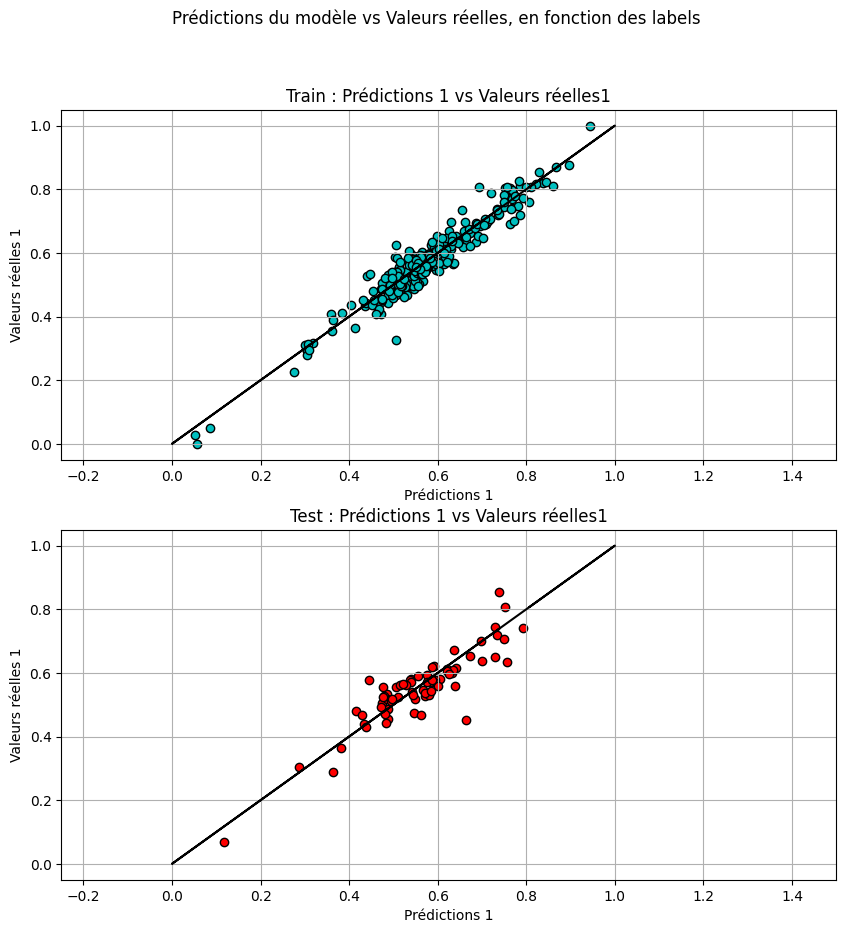

In [ ]:
# Paramètrage + Création de l'estimateur

pls_est = PLSRegression(n_components=30, scale=False, max_iter=1)

# Test

test_dis_impact(features=features,
                labels=labels,
                test_size=test_size,
                dic_res=dic_diss,
                estimator=pls_est,
                n_cluster=n_cluster,
                pca=pca)

#### Xtrem Gradient Boosting

MIN dissimilarité = (cluster, 157)

Score de performance = 1.7168246062753967


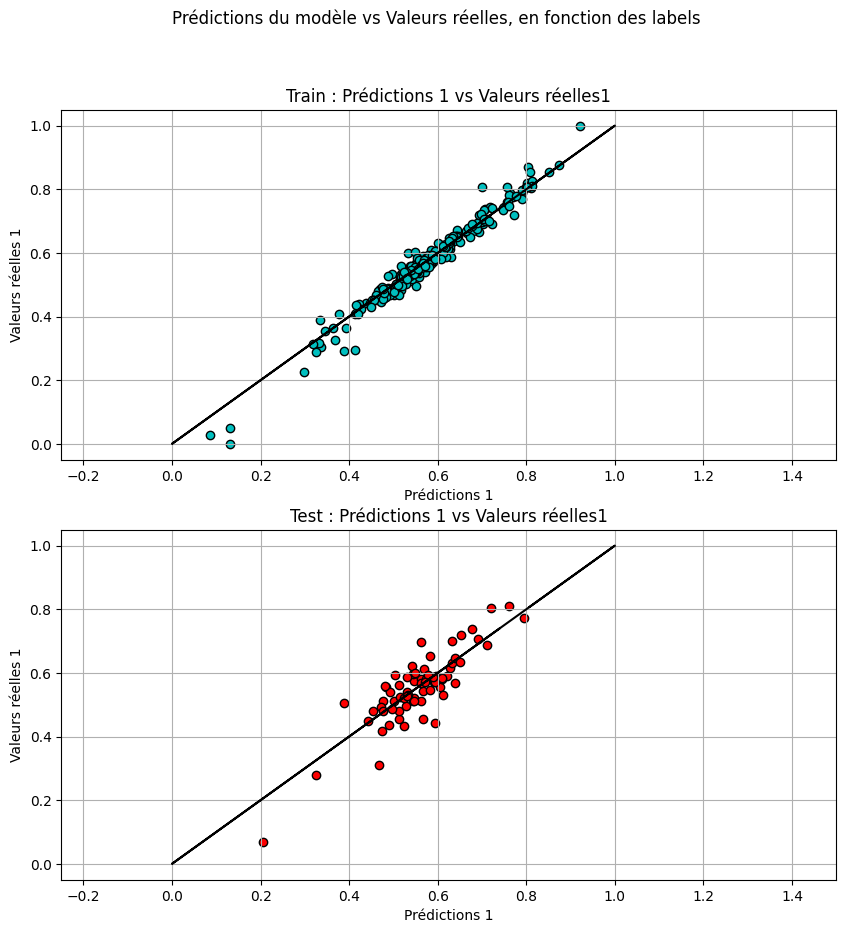

MAX dissimilarité = (custom, 194)

Score de performance = 0.7710953084748422


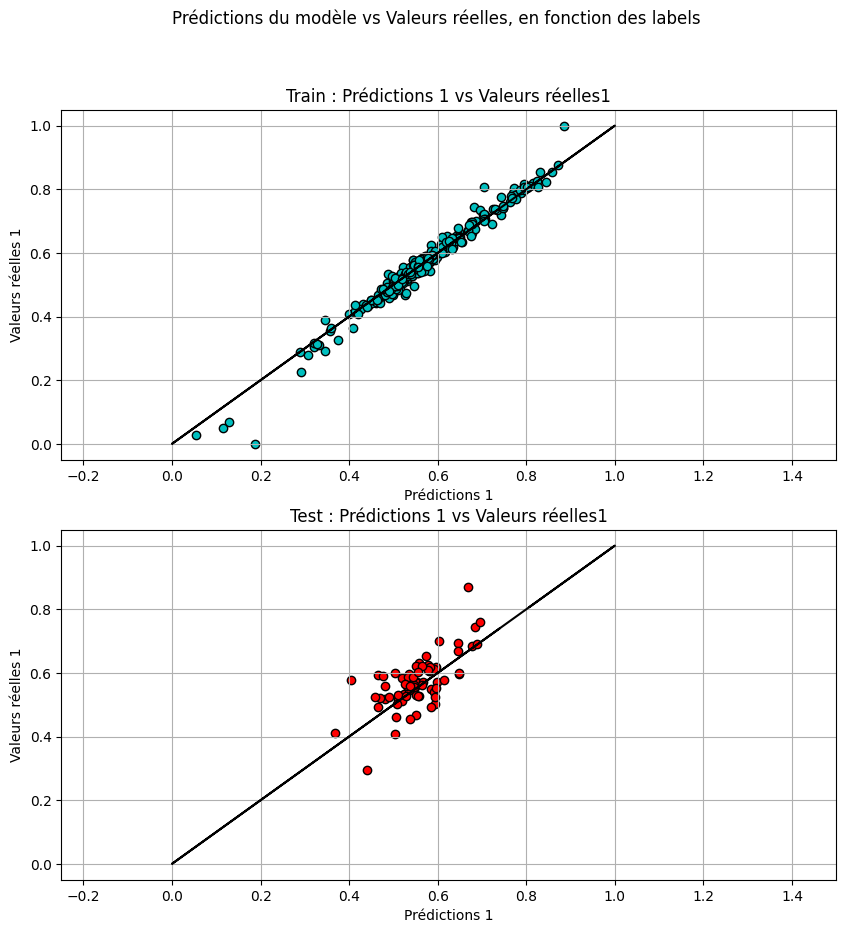

RANDOM dissimilarité = (random, 42)

Score de performance = 1.3519209586224248


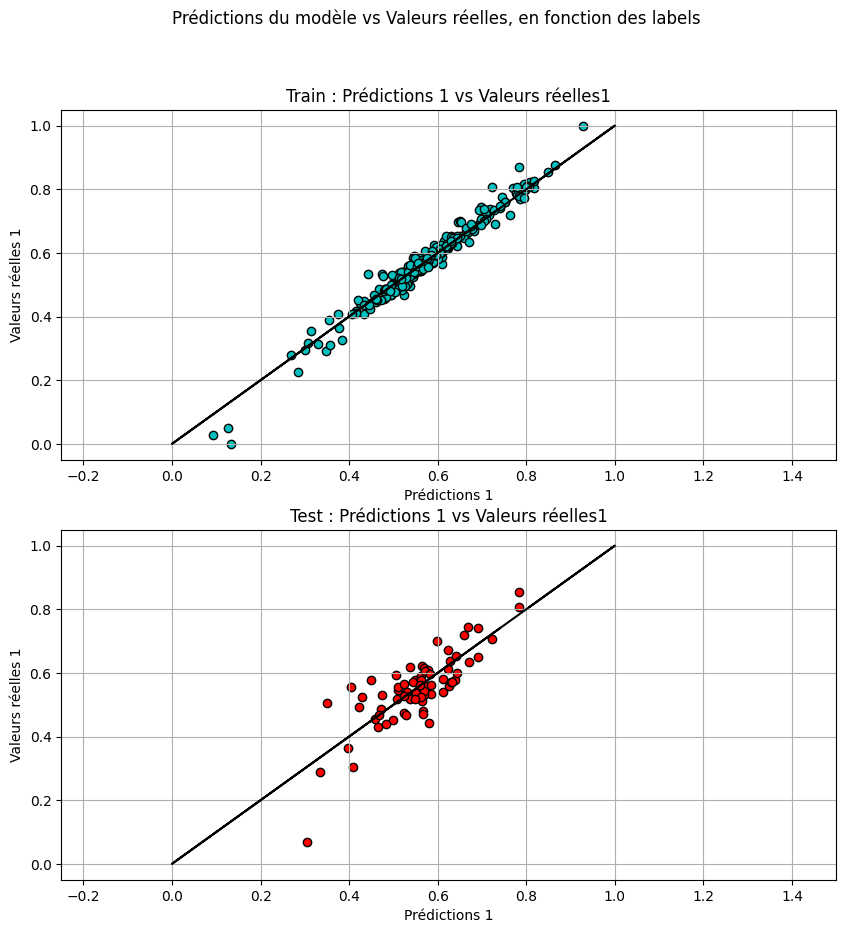

In [ ]:
# Paramètrage + Création de l'estimateur

xgboost_est = XGBRegressor(n_estimators=70, max_depth=10, eta=0.1, subsample=0.25, colsample_bytree=0.5)

# Test

test_dis_impact(features=features,
                labels=labels,
                test_size=test_size,
                dic_res=dic_diss,
                estimator=xgboost_est,
                n_cluster=n_cluster,
                pca=pca)

#### Multi Layers Perceptron Regressor

MIN dissimilarité = (cluster, 157)

Score de performance = 1.798976213815032


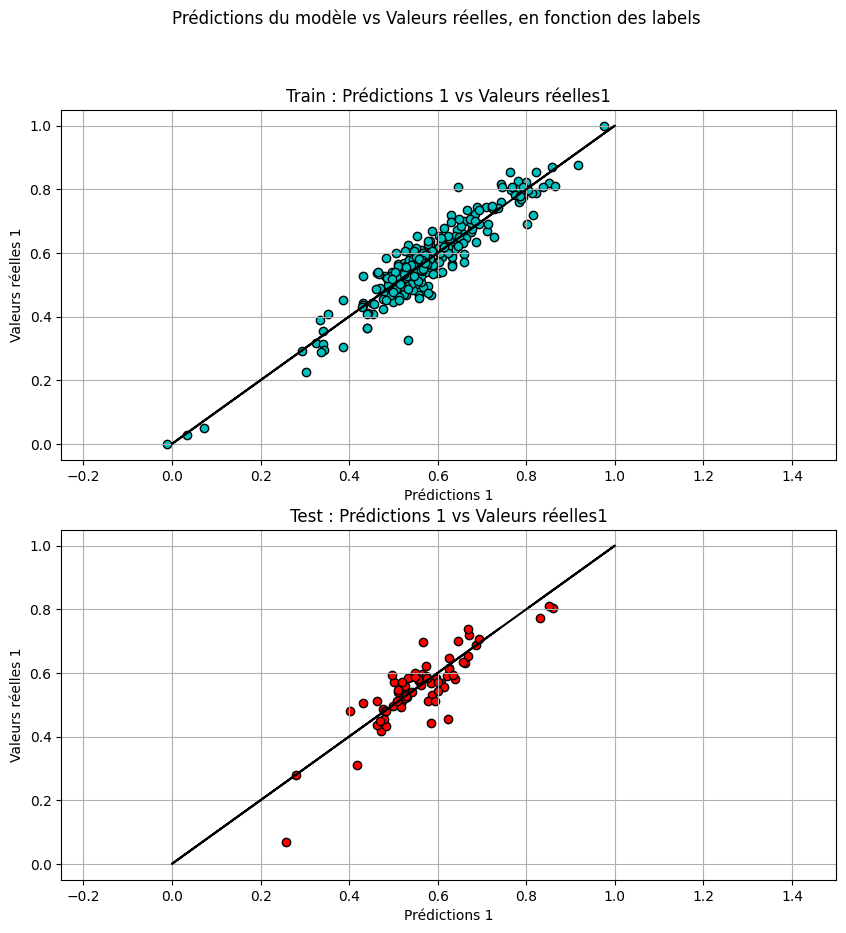

MAX dissimilarité = (custom, 194)

Score de performance = 0.8949153688630271


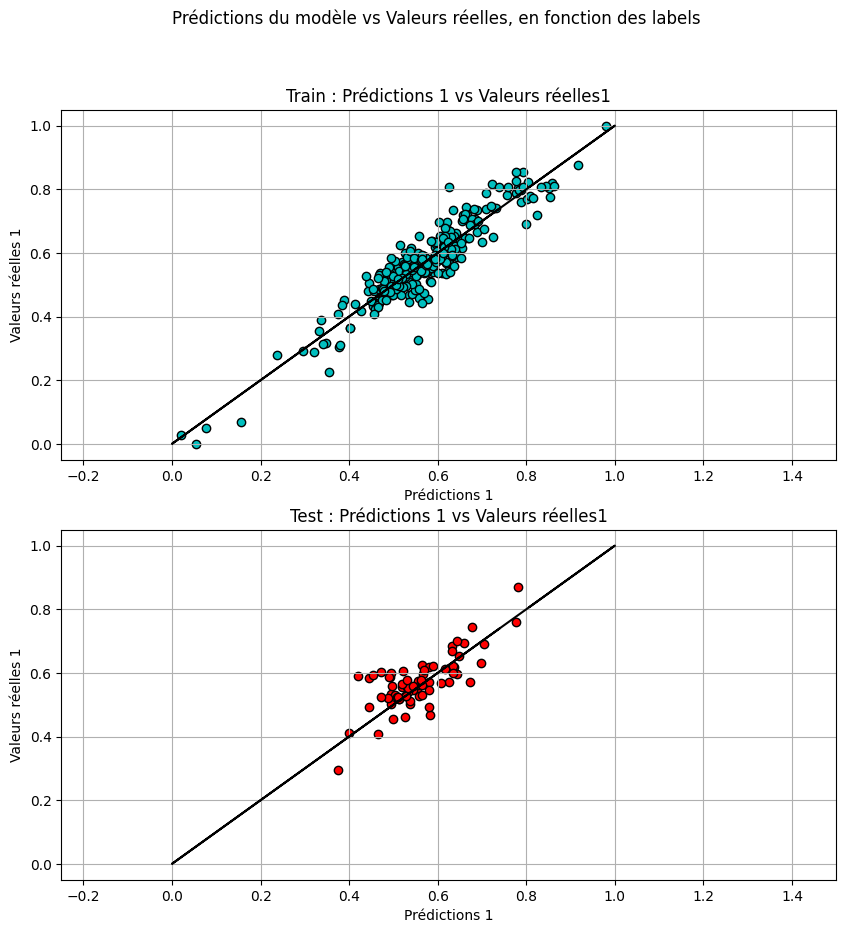

RANDOM dissimilarité = (random, 42)

Score de performance = 1.6677886226792655


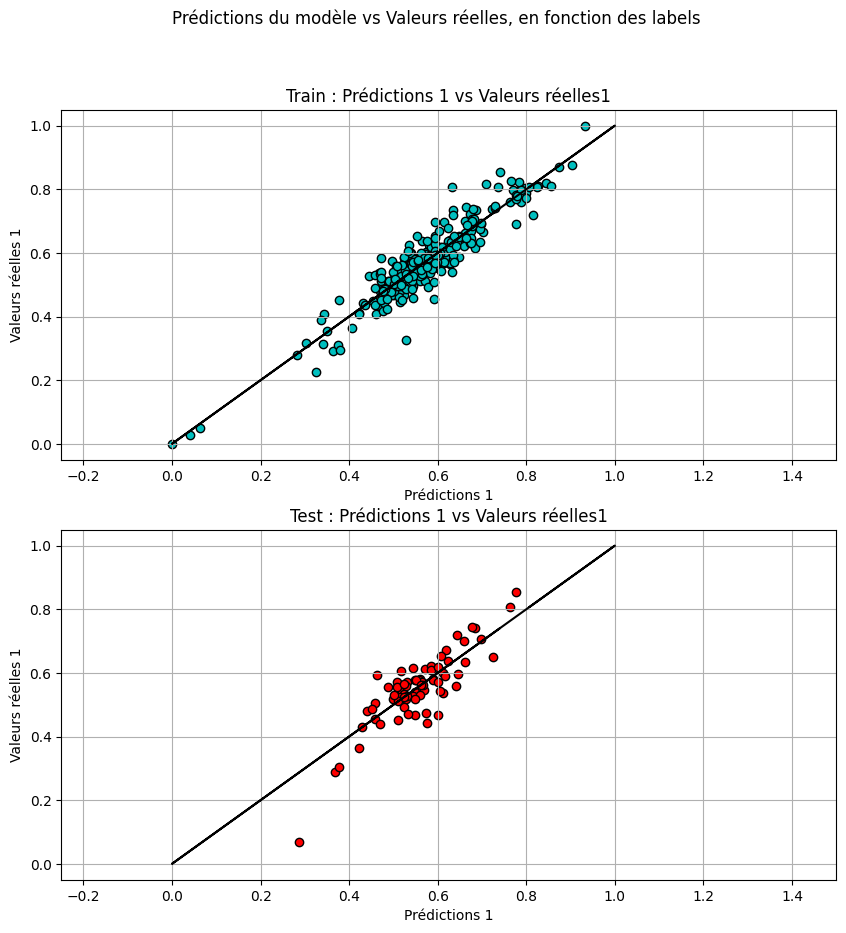

In [ ]:
# Paramètrage du réseau de neurone

hidden_layer_sizes = (30,)
activation = "tanh"
solver = "lbfgs"
epochs = 400

# Création de l'estimateur

mlp_regressor_est = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                 activation=activation,
                                 solver=solver,
                                 max_iter=epochs,
                                 random_state=random_state)

# Test

test_dis_impact(features=features,
                labels=labels,
                test_size=test_size,
                dic_res=dic_diss,
                estimator=mlp_regressor_est,
                n_cluster=n_cluster,
                pca=pca)

#### Keras Regressor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d (SpatialD  (None, 19359, 9)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 3869, 8)           1088      
                                                                 
 dropout (Dropout)           (None, 3869, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1283, 64)          10816     
                                                                 
 batch_normalization (BatchN  (None, 1283, 64)         256       
 ormalization)                                                   


2022-08-26 13:49:40.957428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-26 13:49:40.958216: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-26 13:49:40.958458: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-QLF625S2): /proc/driver/nvidia/version does not exist
2022-08-26 13:49:40.985960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 conv1d_2 (Conv1D)           (None, 427, 32)           10272     
                                                                 
 batch_normalization_1 (Batc  (None, 427, 32)          128       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 13664)             0         
                                                                 
 dense (Dense)               (None, 16)                218640    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 241,217
Trainable params: 241,025
Non-trainable params: 192
_________________________________________________________________
MIN dissimilarité = (cluster, 157)

TRANSFORM
ahahah (72, 19359, 9)


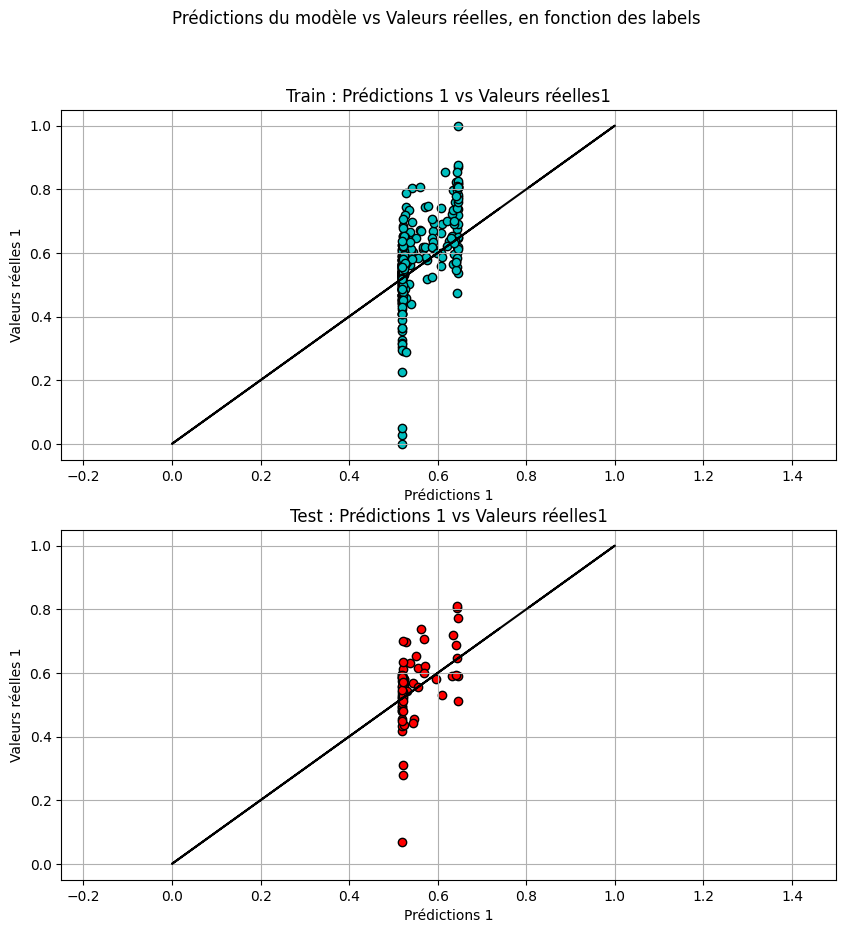

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_1 (Spatia  (None, 19359, 9)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 3869, 8)           1088      
                                                                 
 dropout_1 (Dropout)         (None, 3869, 8)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1283, 64)          10816     
                                                                 
 batch_normalization_2 (Batc  (None, 1283, 64)         256       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 427, 32)          

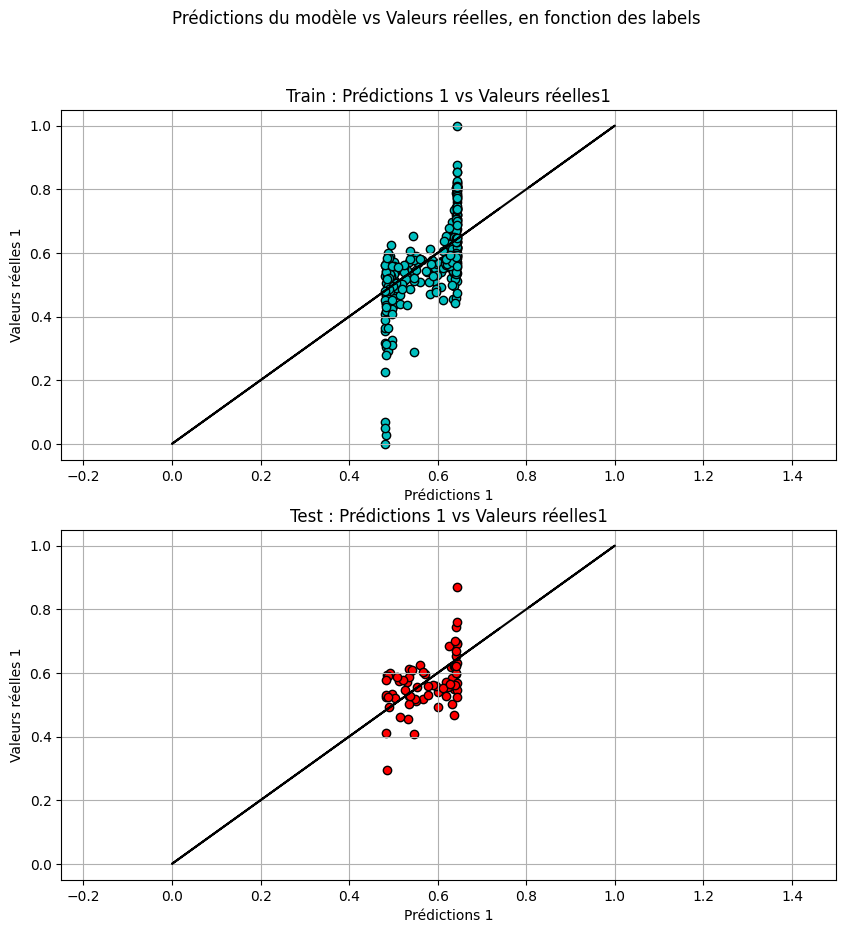

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_2 (Spatia  (None, 19359, 9)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, 3869, 8)           1088      
                                                                 
 dropout_2 (Dropout)         (None, 3869, 8)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 1283, 64)          10816     
                                                                 
 batch_normalization_4 (Batc  (None, 1283, 64)         256       
 hNormalization)                                                 
                                                                 
 conv1d_8 (Conv1D)           (None, 427, 32)          

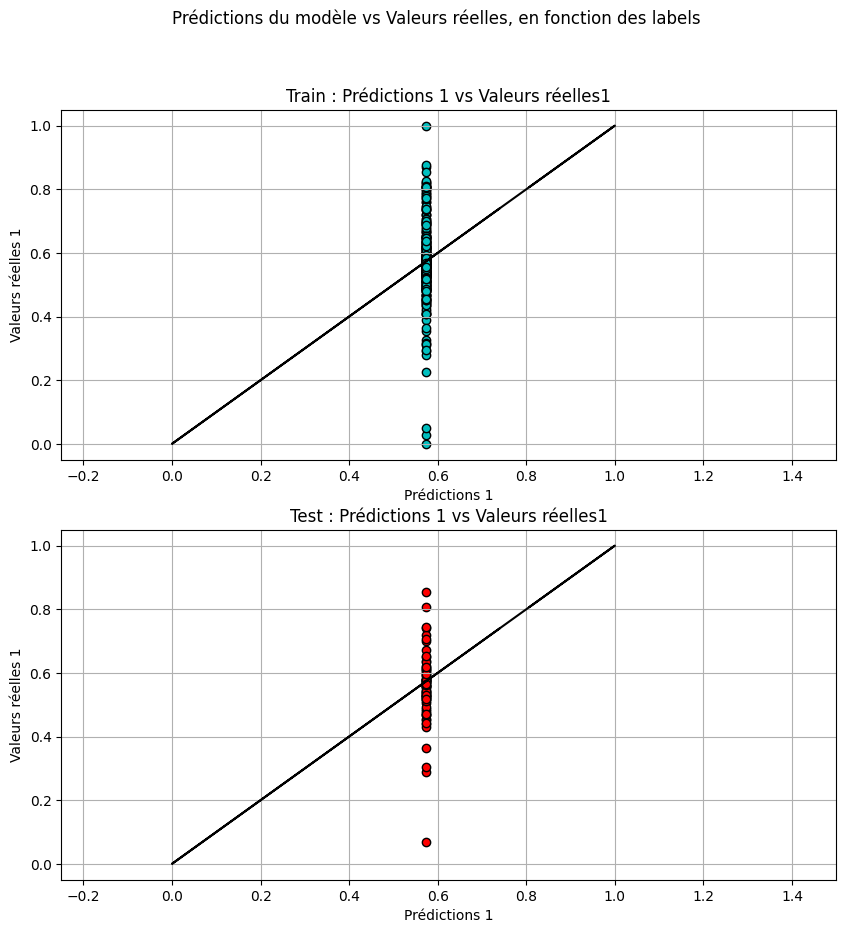

In [ ]:
# Paramètrage du réseau de neurone

k_epochs = 200
fit__batch_size = 50
fit__validation_split = 0.2
verbose = 0

# Création de l'estimateur

k_regressor = KerasRegressor(model=keras_model,
                             epochs=k_epochs, 
                             fit__batch_size=fit__batch_size,
                             fit__validation_split=fit__validation_split,
                             verbose=verbose,
                             random_state=random_state)

k_regressor_est = Pipeline([('preprocessing', FeatureAugmentation(preprocessing)), ('KerasNN', k_regressor)])

# Test

test_dis_impact(features=features,
                labels=labels,
                test_size=test_size,
                dic_res=dic_diss,
                estimator=k_regressor_est,
                n_cluster=n_cluster,
                pca=pca)

### Sauvegarde des modèles

In [ ]:
# Splitting selon la dissililatiré la plus faible

x_train, x_test, y_train, y_test = st.sampling_train_test_split(features=features,
                                                                labels=labels,
                                                                test_size=test_size,
                                                                tech="cluster",
                                                                random_state=157,
                                                                n_cluster=n_cluster,
                                                                pca=pca)

In [ ]:
# PLSR

pls_est.fit(x_train, y_train)

pickle.dump(pls_est, open("Xcal_diss_plsr.sav", "wb"))

In [ ]:
# XGBOOST

xgboost_est.fit(x_train, y_train)

pickle.dump(xgboost_est, open("Xcal_diss_xgboost.sav", "wb"))

In [ ]:
# MLPR

mlp_regressor_est.fit(x_train, y_train)

pickle.dump(mlp_regressor_est, open("Xcal_diss_mlpr.sav", "wb"))

In [ ]:
# KERAS_R

k_regressor_est.fit(x_train, y_train)

pickle.dump(k_regressor_est, open("Xcal_diss_keras_r.sav", "wb"))